# Notes

- [x] Add progress bar
- [x] Add auto arima
- [ ] Add auto skar
- [ ] Add baselines
- [ ] Add metrics
- [x] Add confidence intervals
- [ ] Add residuals
- [ ] Add simple validation metrics

# Setup

In [14]:
%load_ext autoreload
%autoreload 2

In [48]:
import sys
sys.path.append("..")

from dataclasses import dataclass, field
from typing import List, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from ipywidgets import interact, widgets

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

import statsmodels.api as sm
import statsmodels.tsa.api as tsa
import pmdarima as pm

plt.rcParams["figure.figsize"] = (12, 4)

# Data

In [5]:
stocks = pd.read_csv("../data/all_stocks_5yr.csv.gz", parse_dates=["date"])
stocks

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


In [6]:
stocks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619040 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619032 non-null  float64       
 3   low     619032 non-null  float64       
 4   close   619040 non-null  float64       
 5   volume  619040 non-null  int64         
 6   Name    619040 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 33.1+ MB


In [7]:
stocks = stocks.set_index("date").groupby("Name").resample("W").mean().reset_index()
stocks

,Name,date,open,high,low,close,volume
0,A,2013-02-10,45.070000,45.350000,45.000000,45.080000,1824755.00
1,A,2013-02-17,44.598000,44.878000,44.040000,44.160000,5165006.80
2,A,2013-02-24,42.255000,42.545000,41.871250,42.170000,3689833.75
3,A,2013-03-03,41.332000,41.891000,40.898000,41.480000,3985236.20
4,A,2013-03-10,42.780000,43.178000,42.518000,42.842000,2878377.80
...,...,...,...,...,...,...,...
128835,ZTS,2018-01-14,74.334000,75.013000,73.879140,74.648000,2431182.00
128836,ZTS,2018-01-21,76.302500,76.747500,75.667500,76.315000,3196819.50
128837,ZTS,2018-01-28,78.018000,78.784000,77.783000,78.548000,2780926.20
128838,ZTS,2018-02-04,78.222000,78.760000,77.396000,77.772000,3236979.20


# Sandbox

In [8]:
import darts.models
import darts.metrics
from darts.timeseries import TimeSeries
from warnings import filterwarnings
filterwarnings('ignore')

In [9]:
#data = stocks[stocks.Name.isin(["A", "AAL"])]
data = stocks[stocks.Name.isin(["A"])]

In [10]:
data

,Name,date,open,high,low,close,volume
0,A,2013-02-10,45.070,45.350000,45.00000,45.080000,1.824755e+06
1,A,2013-02-17,44.598,44.878000,44.04000,44.160000,5.165007e+06
2,A,2013-02-24,42.255,42.545000,41.87125,42.170000,3.689834e+06
3,A,2013-03-03,41.332,41.891000,40.89800,41.480000,3.985236e+06
4,A,2013-03-10,42.780,43.178000,42.51800,42.842000,2.878378e+06
...,...,...,...,...,...,...,...
257,A,2018-01-14,70.702,71.430000,70.12500,71.028000,2.039419e+06
258,A,2018-01-21,72.105,72.623750,71.59500,72.137500,1.905580e+06
259,A,2018-01-28,73.870,74.161000,73.22800,73.836000,1.796494e+06
260,A,2018-02-04,73.548,74.002000,72.84000,73.006000,1.827100e+06


In [11]:
from tstools.forecast.single_ts import Univariate
from tstools.forecast.single_ts import Naive
from tstools.forecast.single_ts import AutoARIMA

In [328]:
from typing_extensions import Protocol

In [329]:
class ScikitModel(Protocol):
    def fit(self, X, y, sample_weight=None): ...
    def predict(self, X): ...
    def score(self, X, y, sample_weight=None): ...
    def set_params(self, **params): ...
    def get_params(self, deep=True): ...

In [727]:
@dataclass
class Regression(Univariate):
    model: ScikitModel = None
    scale_regressors: bool = True
    n_lags: int = 0
        
    def build_lags(self, ts):
        lags = pd.concat([ts.shift(i) for i in range(self.n_lags + 1)], axis=1).dropna()
        lags.columns = [ts.name + f"_lag_{i}" for i in range(self.n_lags + 1)]
        return lags
    
    def build_target(self, ts):
        target = ts.shift(-1).dropna()
        target.name = "target"
        return target
    
    def fit(self, data):
        self.data = data.copy()
        ts = self.get_indexed_series(data, self.target_col)
        extra_regressors = self.get_indexed_series(data, self.regressor_cols)
        lags = self.build_lags(ts)
        target = self.build_target(ts)
        df = pd.concat([target, lags, extra_regressors], axis=1, join="inner")
        y = df.iloc[:, 0].to_numpy()
        X = df.iloc[:, 1:].to_numpy()
        if self.scale_regressors:
            self.scaler = StandardScaler()
            X = self.scaler.fit_transform(X)
        self.model.fit(X, y)
        return self
    
    def predict(self, future):
        future = future.copy()
        fh = len(future)
        ts = self.get_indexed_series(self.data, self.target_col).to_numpy()
        extra_regressors = self.get_indexed_series(future, self.regressor_cols).to_numpy()
        for i, row in future.iterrows():
            lags = ts[-self.n_lags - 1:].reshape(1, -1)
            reg = extra_regressors[i].reshape(1, -1)
            X = np.concatenate([lags, reg], axis=1)
            if self.scale_regressors:
                X = self.scaler.transform(X)
            y_pred = self.model.predict(X)
            ts = np.append(ts, [y_pred])
        future[self.target_col + "_fcst"] = ts[-fh:]
        return future

In [718]:
train = data.iloc[:-10]
test = data.iloc[-10:]

In [719]:
model = Regression(time_col="date", target_col="open", regressor_cols=["close"], freq="W", model=LinearRegression(), scale_regressors=True, n_lags=10)

In [720]:
model.fit(train)

Regression(time_col='date', target_col='open', regressor_cols=['close'], freq='W', model=LinearRegression(), scale_regressors=True, n_lags=10)

In [721]:
future = model.get_future_dataframe(train, fh=10)

In [722]:
future["close"] = test["close"].to_numpy()

In [723]:
future

,date,close
0,2017-12-10,66.410000
1,2017-12-17,66.972000
2,2017-12-24,67.536000
3,2017-12-31,67.242500
4,2018-01-07,68.905000
5,2018-01-14,71.028000
6,2018-01-21,72.137500
7,2018-01-28,73.836000
8,2018-02-04,73.006000
9,2018-02-11,68.243333


In [724]:
fcst = model.predict(future)

[[66.076  64.594  65.206  66.826  66.778  67.6    67.982  68.366  67.35
  69.3275 69.488 ]]
[[66.41]]
[[66.076  64.594  65.206  66.826  66.778  67.6    67.982  68.366  67.35
  69.3275 69.488  66.41  ]]
[66.50093817]
[[64.594      65.206      66.826      66.778      67.6        67.982
  68.366      67.35       69.3275     69.488      66.50093817]]
[[66.972]]
[[64.594      65.206      66.826      66.778      67.6        67.982
  68.366      67.35       69.3275     69.488      66.50093817 66.972     ]]
[70.23794884]
[[65.206      66.826      66.778      67.6        67.982      68.366
  67.35       69.3275     69.488      66.50093817 70.23794884]]
[[67.536]]
[[65.206      66.826      66.778      67.6        67.982      68.366
  67.35       69.3275     69.488      66.50093817 70.23794884 67.536     ]]
[70.5263]
[[66.826      66.778      67.6        67.982      68.366      67.35
  69.3275     69.488      66.50093817 70.23794884 70.5263    ]]
[[67.2425]]
[[66.826      66.778      67.6        

In [725]:
fcst

,date,close,open_fcst
0,2017-12-10,66.410000,66.500938
1,2017-12-17,66.972000,70.237949
2,2017-12-24,67.536000,70.526300
3,2017-12-31,67.242500,67.774583
4,2018-01-07,68.905000,71.617709
5,2018-01-14,71.028000,75.601059
6,2018-01-21,72.137500,77.397893
7,2018-01-28,73.836000,80.695185
8,2018-02-04,73.006000,80.658217
9,2018-02-11,68.243333,66.538324


<AxesSubplot:xlabel='date'>

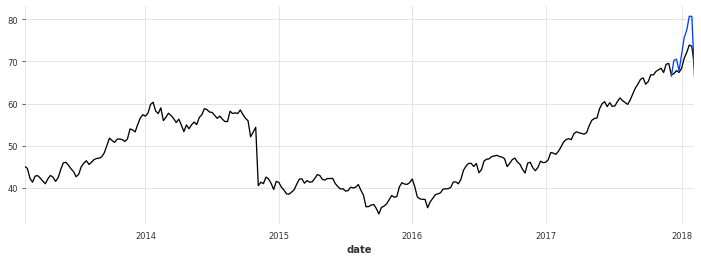

In [726]:
data.set_index("date")["open"].plot()
fcst.set_index("date")["open_fcst"].plot()

In [435]:
ts = data[["date", "open"]]

In [436]:
ts = data.set_index("date")["open"]

In [437]:
ts

date
2013-02-10    45.070
2013-02-17    44.598
2013-02-24    42.255
2013-03-03    41.332
2013-03-10    42.780
               ...  
2018-01-14    70.702
2018-01-21    72.105
2018-01-28    73.870
2018-02-04    73.548
2018-02-11    68.670
Name: open, Length: 262, dtype: float64

In [439]:
data

,Name,date,open,high,low,close,volume
0,A,2013-02-10,45.070,45.350000,45.00000,45.080000,1.824755e+06
1,A,2013-02-17,44.598,44.878000,44.04000,44.160000,5.165007e+06
2,A,2013-02-24,42.255,42.545000,41.87125,42.170000,3.689834e+06
3,A,2013-03-03,41.332,41.891000,40.89800,41.480000,3.985236e+06
4,A,2013-03-10,42.780,43.178000,42.51800,42.842000,2.878378e+06
...,...,...,...,...,...,...,...
257,A,2018-01-14,70.702,71.430000,70.12500,71.028000,2.039419e+06
258,A,2018-01-21,72.105,72.623750,71.59500,72.137500,1.905580e+06
259,A,2018-01-28,73.870,74.161000,73.22800,73.836000,1.796494e+06
260,A,2018-02-04,73.548,74.002000,72.84000,73.006000,1.827100e+06


In [438]:
def build_lags(ts):
    lags = pd.concat([ts.shift(i) for i in range(5 + 1)], axis=1).dropna()
    lags.columns = [ts.name + f"_lag_{i}" for i in range(5 + 1)]
    return lags

In [208]:
def build_target(ts):
    target = ts.shift(-1).dropna()
    target.name = "target"
    return target

In [224]:
lags = build_lags(ts)
target = build_target(ts)
df = lags.join(target, how="inner")

In [225]:
df

,open_lag_0,open_lag_1,open_lag_2,open_lag_3,open_lag_4,open_lag_5,target
date,,,,,,,
2013-03-17,42.8960,42.7800,41.3320,42.2550,44.5980,45.070,42.3260
2013-03-24,42.3260,42.8960,42.7800,41.3320,42.2550,44.598,41.5925
2013-03-31,41.5925,42.3260,42.8960,42.7800,41.3320,42.255,40.9700
2013-04-07,40.9700,41.5925,42.3260,42.8960,42.7800,41.332,42.1580
2013-04-14,42.1580,40.9700,41.5925,42.3260,42.8960,42.780,42.9400
...,...,...,...,...,...,...,...
2018-01-07,68.3275,67.3650,67.8060,67.0940,66.7740,69.488,70.7020
2018-01-14,70.7020,68.3275,67.3650,67.8060,67.0940,66.774,72.1050
2018-01-21,72.1050,70.7020,68.3275,67.3650,67.8060,67.094,73.8700


In [226]:
y = df.iloc[:, 0].to_numpy()
X = df.iloc[:, 1:].to_numpy()

In [227]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-0.69608635, -0.85204331, -0.74546268, -0.4760758 , -0.41598551,
        -0.75452533],
       [-0.68337185, -0.69122182, -0.84921145, -0.74248057, -0.4701619 ,
        -0.83330102],
       [-0.74584826, -0.67833833, -0.68645065, -0.84742791, -0.73909255,
        -0.90015565],
       ...,
       [ 2.3643806 ,  2.14620015,  2.07699848,  2.16272994,  2.11193966,
         2.63320538],
       [ 2.51816024,  2.40992296,  2.1851872 ,  2.11258717,  2.19366335,
         2.59862355],
       [ 2.71161788,  2.56574655,  2.45209019,  2.22202575,  2.14304517,
         2.07474102]])

In [228]:
model = LinearRegression()

In [229]:
model.fit(X, y)

LinearRegression()

In [293]:
future

,date
0,2018-02-18
1,2018-02-25
2,2018-03-04
3,2018-03-11
4,2018-03-18


In [313]:
list(future.iterrows())[0]

(0,
 date   2018-02-18
 Name: 0, dtype: datetime64[ns])

In [307]:
i, value = list(future.itertuples())[0]

In [309]:
value

Timestamp('2018-02-18 00:00:00')

In [279]:
ts = data.set_index("date")["open"]

In [319]:
list(future.iterrows())

[(0,
  date   2018-02-18
  Name: 0, dtype: datetime64[ns]),
 (1,
  date   2018-02-25
  Name: 1, dtype: datetime64[ns]),
 (2,
  date   2018-03-04
  Name: 2, dtype: datetime64[ns]),
 (3,
  date   2018-03-11
  Name: 3, dtype: datetime64[ns]),
 (4,
  date   2018-03-18
  Name: 4, dtype: datetime64[ns])]

In [325]:
ts = data.set_index("date")["open"]
ts

date
2013-02-10    45.070
2013-02-17    44.598
2013-02-24    42.255
2013-03-03    41.332
2013-03-10    42.780
               ...  
2018-01-14    70.702
2018-01-21    72.105
2018-01-28    73.870
2018-02-04    73.548
2018-02-11    68.670
Name: open, Length: 262, dtype: float64

In [321]:
ts = data.set_index("date")["open"]

for i, datestamp in future.iterrows():
    X = build_lags(ts).tail(1).to_numpy()
    X = scaler.transform(X)
    y_pred = model.predict(X)
    ts = ts.append(pd.Series(y_pred, index=datestamp), ignore_index=False)
    ts.name = "open"

In [326]:
future

,date
0,2018-02-18
1,2018-02-25
2,2018-03-04
3,2018-03-11
4,2018-03-18


In [323]:
ts

2013-02-10    45.070000
2013-02-17    44.598000
2013-02-24    42.255000
2013-03-03    41.332000
2013-03-10    42.780000
                ...    
2018-02-18    68.283892
2018-02-25    69.931944
2018-03-04    71.139714
2018-03-11    72.547240
2018-03-18    73.155967
Name: open, Length: 267, dtype: float64

In [280]:
build_lags(ts)

,open_lag_0,open_lag_1,open_lag_2,open_lag_3,open_lag_4,open_lag_5
date,,,,,,
2013-03-17,42.8960,42.7800,41.3320,42.2550,44.5980,45.0700
2013-03-24,42.3260,42.8960,42.7800,41.3320,42.2550,44.5980
2013-03-31,41.5925,42.3260,42.8960,42.7800,41.3320,42.2550
2013-04-07,40.9700,41.5925,42.3260,42.8960,42.7800,41.3320
2013-04-14,42.1580,40.9700,41.5925,42.3260,42.8960,42.7800
...,...,...,...,...,...,...
2018-01-14,70.7020,68.3275,67.3650,67.8060,67.0940,66.7740
2018-01-21,72.1050,70.7020,68.3275,67.3650,67.8060,67.0940
2018-01-28,73.8700,72.1050,70.7020,68.3275,67.3650,67.8060


In [281]:
X = build_lags(ts).tail(1).to_numpy()

In [282]:
X = scaler.transform(X)

In [283]:
y_pred = model.predict(X)

In [284]:
ts = ts.append(pd.Series(y_pred, index=future.iloc[0]), ignore_index=False)
ts.name = "open"

In [285]:
ts

2013-02-10    45.070000
2013-02-17    44.598000
2013-02-24    42.255000
2013-03-03    41.332000
2013-03-10    42.780000
                ...    
2018-01-21    72.105000
2018-01-28    73.870000
2018-02-04    73.548000
2018-02-11    68.670000
2018-02-18    68.283892
Name: open, Length: 263, dtype: float64

In [286]:
X = build_lags(ts).tail(1).to_numpy()

In [287]:
X = scaler.transform(X)

In [288]:
y_pred = model.predict(X)

In [289]:
ts = ts.append(pd.Series(y_pred, index=future.iloc[1]), ignore_index=False)
ts.name = "open"

In [290]:
ts

2013-02-10    45.070000
2013-02-17    44.598000
2013-02-24    42.255000
2013-03-03    41.332000
2013-03-10    42.780000
                ...    
2018-01-28    73.870000
2018-02-04    73.548000
2018-02-11    68.670000
2018-02-18    68.283892
2018-02-25    69.931944
Name: open, Length: 264, dtype: float64

In [175]:
npc

array([[-0.69608635, -0.85204331, -0.74546268, -0.4760758 , -0.41598551,
        -0.75452533],
       [-0.68337185, -0.69122182, -0.84921145, -0.74248057, -0.4701619 ,
        -0.83330102],
       [-0.74584826, -0.67833833, -0.68645065, -0.84742791, -0.73909255,
        -0.90015565],
       ...,
       [ 2.3643806 ,  2.14620015,  2.07699848,  2.16272994,  2.11193966,
         2.63320538],
       [ 2.51816024,  2.40992296,  2.1851872 ,  2.11258717,  2.19366335,
         2.59862355],
       [ 2.71161788,  2.56574655,  2.45209019,  2.22202575,  2.14304517,
         2.07474102]])

In [174]:
y_pred

array([71.4573988])

In [166]:
future = Univariate(time_col="date", target_col="open", regressor_cols=None, freq="W").get_future_dataframe(data, fh=5)

In [167]:
future

,date
0,2018-02-18
1,2018-02-25
2,2018-03-04
3,2018-03-11
4,2018-03-18


In [154]:
future["open"] = y_pred[-1]

In [155]:
future

,date,open
0,2018-02-18,71.457399


In [162]:
ts.append(future, ignore_index=True)

,date,open
0,2013-02-10,45.070000
1,2013-02-17,44.598000
2,2013-02-24,42.255000
3,2013-03-03,41.332000
4,2013-03-10,42.780000
...,...,...
258,2018-01-21,72.105000
259,2018-01-28,73.870000
260,2018-02-04,73.548000
261,2018-02-11,68.670000


In [140]:
y_pred[-1]

71.45739879997181

In [139]:
ts.append(pd.Series(y_pred[-1]))

2013-02-10 00:00:00    45.070000
2013-02-17 00:00:00    44.598000
2013-02-24 00:00:00    42.255000
2013-03-03 00:00:00    41.332000
2013-03-10 00:00:00    42.780000
                         ...    
2018-01-21 00:00:00    72.105000
2018-01-28 00:00:00    73.870000
2018-02-04 00:00:00    73.548000
2018-02-11 00:00:00    68.670000
0                      71.457399
Length: 263, dtype: float64

In [131]:
y_pred

array([42.69527727, 42.13621876, 41.63998036, 41.8414781 , 41.92819968,
       42.44204235, 42.18939696, 42.37425289, 42.87460317, 44.24991873,
       45.22085276, 45.60821933, 45.19458386, 44.56541167, 43.57166193,
       43.5410143 , 43.749853  , 44.63875867, 45.76559546, 45.62290406,
       46.25791643, 45.99452787, 46.63764481, 46.83592579, 47.15564234,
       47.66181858, 48.7336911 , 50.07139738, 50.70219424, 51.29057485,
       51.21868681, 51.22692546, 51.56565403, 51.25023879, 51.53208813,
       52.44514907, 52.74505213, 53.76426224, 54.18034099, 54.92468186,
       56.32523256, 56.7517315 , 57.53018305, 58.30179815, 59.10529738,
       59.12178413, 58.90498086, 58.46766264, 56.9662666 , 58.03443928,
       56.51276706, 57.34859322, 57.03738819, 56.30746856, 56.39949383,
       55.21103147, 55.01391028, 54.76177495, 53.72749168, 55.19565735,
       54.58664698, 55.21347304, 56.08920774, 56.11050814, 57.92887428,
       57.85040484, 58.51444919, 58.11809698, 57.6216219 , 57.26

In [130]:
len(y_pred)

256

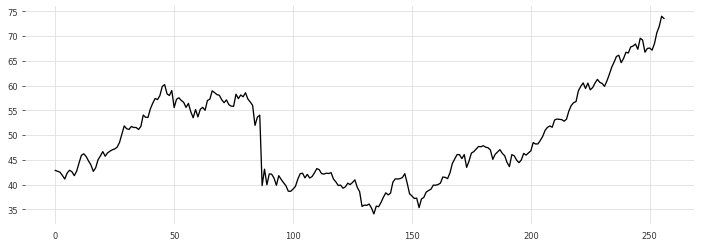

In [103]:
plt.plot(y_pred)

<AxesSubplot:xlabel='date'>

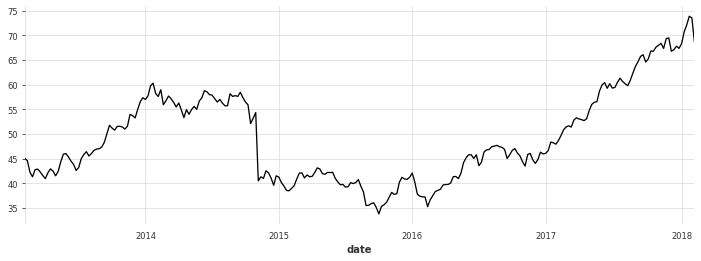

In [40]:
y.plot()

In [ ]:
model: ScikitModel = None
scale_regressors: bool = True
    n_lags: int = 0

    def build_lags(self, y):
        lags = pd.concat([y.shift(i) for i in range(self.n_lags + 1)], axis=1).dropna()
        return lags

    def build_target(self, y):
        target = pd.concat([y.shift(-i) for i in range(1, self.fh + 1)], axis=1).dropna()
        return target

In [41]:
y

date
2013-02-10    45.070
2013-02-17    44.598
2013-02-24    42.255
2013-03-03    41.332
2013-03-10    42.780
               ...  
2018-01-14    70.702
2018-01-21    72.105
2018-01-28    73.870
2018-02-04    73.548
2018-02-11    68.670
Name: open, Length: 262, dtype: float64

In [27]:
model = Naive(time_col="date", target_col="close", regressor_cols=None, freq="W")

In [28]:
model.fit(data)

Naive(time_col='date', target_col='close', regressor_cols=None, freq='W')

In [14]:
future = model.get_future_dataframe(data, fh=10)

In [15]:
y_fcst = model.predict(future)

<AxesSubplot:xlabel='date'>

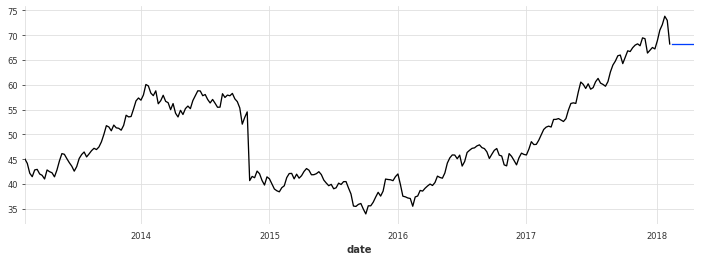

In [16]:
data.set_index("date")["close"].plot()
y_fcst.set_index("date")["y_fcst"].plot()

In [17]:
y_hfcst = model.historical_forecasts(data, fh=10)

100%|██████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 2649.40it/s]


In [18]:
y_hfcst[0]

,date,y_fcst
0,2015-08-16,40.49
1,2015-08-23,40.49
2,2015-08-30,40.49
3,2015-09-06,40.49
4,2015-09-13,40.49
5,2015-09-20,40.49
6,2015-09-27,40.49
7,2015-10-04,40.49
8,2015-10-11,40.49
9,2015-10-18,40.49


<AxesSubplot:xlabel='date'>

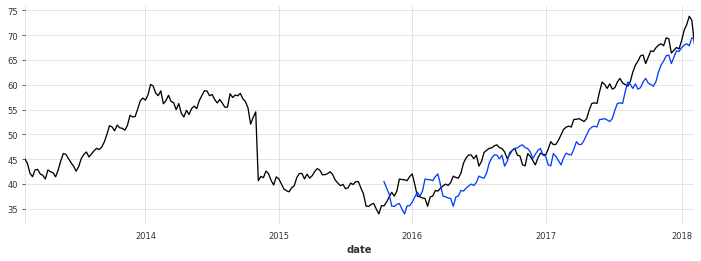

In [52]:
data.set_index("date")["close"].plot()
pd.concat([y_fcst.tail(1) for y_fcst in y_hfcst]).set_index("date")["y_fcst"].plot()

In [55]:
import pmdarima as pm

In [58]:
y = data.set_index("date")["open"]

In [74]:
arima = pm.AutoARIMA()

In [75]:
arima.fit(y)

AutoARIMA()

In [61]:
y_pred = arima.predict()

In [62]:
y_pred

array([68.67, 68.67, 68.67, 68.67, 68.67, 68.67, 68.67, 68.67, 68.67,
       68.67])

In [66]:
model = Univariate(time_col="date", target_col="close", regressor_cols=None, freq="W")

In [68]:
future = model.get_future_dataframe(data, fh=10)

In [70]:
future["y_fcst"] = y_pred

In [71]:
future

,date,y_fcst
0,2018-02-18,68.67
1,2018-02-25,68.67
2,2018-03-04,68.67
3,2018-03-11,68.67
4,2018-03-18,68.67
5,2018-03-25,68.67
6,2018-04-01,68.67
7,2018-04-08,68.67
8,2018-04-15,68.67
9,2018-04-22,68.67


In [191]:
data

,Name,date,open,high,low,close,volume
0,A,2013-02-10,45.070,45.350000,45.00000,45.080000,1.824755e+06
1,A,2013-02-17,44.598,44.878000,44.04000,44.160000,5.165007e+06
2,A,2013-02-24,42.255,42.545000,41.87125,42.170000,3.689834e+06
3,A,2013-03-03,41.332,41.891000,40.89800,41.480000,3.985236e+06
4,A,2013-03-10,42.780,43.178000,42.51800,42.842000,2.878378e+06
...,...,...,...,...,...,...,...
257,A,2018-01-14,70.702,71.430000,70.12500,71.028000,2.039419e+06
258,A,2018-01-21,72.105,72.623750,71.59500,72.137500,1.905580e+06
259,A,2018-01-28,73.870,74.161000,73.22800,73.836000,1.796494e+06
260,A,2018-02-04,73.548,74.002000,72.84000,73.006000,1.827100e+06


In [29]:
model = AutoARIMA(time_col="date", target_col="close", regressor_cols=None, freq="W")

In [30]:
model.fit(data)

AutoARIMA(time_col='date', target_col='close', regressor_cols=None, freq='W', arima_params={}, fit_params={})

In [31]:
fcst = model.predict(model.get_future_dataframe(data, fh=10), conf_int=0.95)

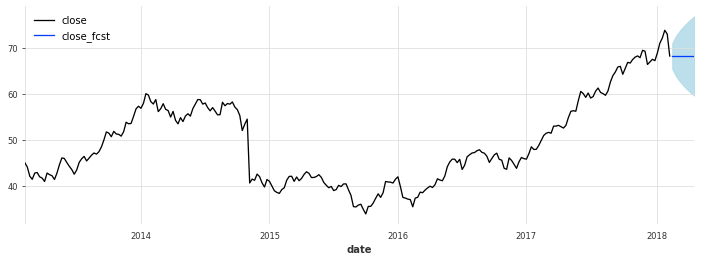

In [32]:
model.plot_fcst(fcst)

In [33]:
hfcst = model.historical_forecasts(data, fh=10)

100%|████████████████████████████████████████████████████████████████████████████████| 122/122 [00:55<00:00,  2.19it/s]


In [34]:
hfcst[1]

,date,close_fcst
0,2015-08-23,39.198
1,2015-08-30,39.198
2,2015-09-06,39.198
3,2015-09-13,39.198
4,2015-09-20,39.198
5,2015-09-27,39.198
6,2015-10-04,39.198
7,2015-10-11,39.198
8,2015-10-18,39.198
9,2015-10-25,39.198


In [182]:
hfcst_ex = [fcst.merge(data[[self.time_col, self.target_col]], on="date") for fcst in hfcst]

[        date  close_fcst
 0 2015-08-16       40.49
 1 2015-08-23       40.49
 2 2015-08-30       40.49
 3 2015-09-06       40.49
 4 2015-09-13       40.49
 5 2015-09-20       40.49
 6 2015-09-27       40.49
 7 2015-10-04       40.49
 8 2015-10-11       40.49
 9 2015-10-18       40.49,
         date  close_fcst
 0 2015-08-23      39.198
 1 2015-08-30      39.198
 2 2015-09-06      39.198
 3 2015-09-13      39.198
 4 2015-09-20      39.198
 5 2015-09-27      39.198
 6 2015-10-04      39.198
 7 2015-10-11      39.198
 8 2015-10-18      39.198
 9 2015-10-25      39.198,
         date  close_fcst
 0 2015-08-30      37.996
 1 2015-09-06      37.996
 2 2015-09-13      37.996
 3 2015-09-20      37.996
 4 2015-09-27      37.996
 5 2015-10-04      37.996
 6 2015-10-11      37.996
 7 2015-10-18      37.996
 8 2015-10-25      37.996
 9 2015-11-01      37.996,
         date  close_fcst
 0 2015-09-06      35.562
 1 2015-09-13      35.562
 2 2015-09-20      35.562
 3 2015-09-27      35.562
 4 2015-1

In [181]:
model.error_table(data, hfcst).mean(axis=0)

0     -4.458150
1     -3.452950
2     -2.313350
3      0.397250
4      0.687650
         ...   
117    0.295550
118    0.418100
119    1.399100
120    0.157700
121    0.227633
Length: 122, dtype: float64

In [208]:
hfcst_last = pd.concat([fcst.tail(1) for fcst in hfcst])

In [209]:
hfcst_last

,date,close_fcst
9,2015-10-18,40.490
9,2015-10-25,39.198
9,2015-11-01,37.996
9,2015-11-08,35.562
9,2015-11-15,35.480
...,...,...
9,2018-01-14,68.008
9,2018-01-21,68.272
9,2018-01-28,67.886
9,2018-02-04,69.480


<AxesSubplot:xlabel='date'>

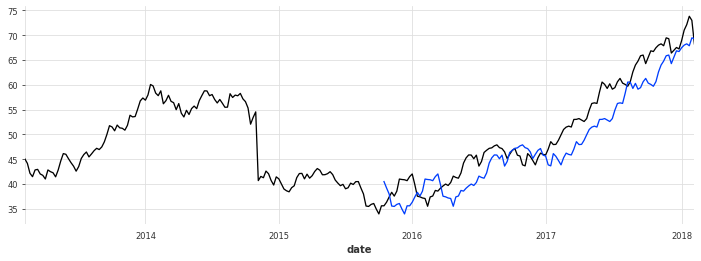

In [210]:
data.set_index("date")["close"].plot()
hfcst_last.set_index("date")["close_fcst"].plot()

In [152]:
err_table = pd.concat([fcst["close_fcst"] for fcst in hfcst], axis=1)

In [154]:
err_table.shape

(10, 122)

In [156]:
err_table.columns = np.arange(0, err_table.shape[1])

In [157]:
err_table

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,40.654550,39.380684,38.191348,35.776982,35.691165,36.097484,36.272096,35.141544,34.173410,35.798489,...,64.115793,65.420299,66.706295,66.566182,67.351733,67.841990,68.130160,67.792899,69.394457,69.155111
1,40.814539,39.558532,38.381784,35.987104,35.897635,36.297872,36.467719,35.340817,34.372804,35.988828,...,63.951592,65.260387,66.552164,66.413916,67.188770,67.743370,67.974680,67.742599,69.248691,69.010618
2,40.970092,39.731671,38.567431,36.192474,36.099514,36.493766,36.658969,35.535909,34.568264,36.175106,...,63.789373,65.102245,66.399591,66.263185,67.027497,67.686489,67.820700,67.584842,69.104192,68.867386
3,41.121333,39.900228,38.748409,36.393200,36.296906,36.685267,36.845944,35.726908,34.759865,36.357408,...,63.629112,64.945853,66.248561,66.113974,66.867895,67.569613,67.668208,67.391888,68.960948,68.725403
4,41.268381,40.064322,38.924836,36.589387,36.489909,36.872473,37.028740,35.913899,34.947685,36.535821,...,63.470785,64.791192,66.099057,65.966268,66.709948,67.407146,67.517187,67.172642,68.818948,68.584658
5,41.411352,40.224072,39.096827,36.781138,36.678621,37.055481,37.207450,36.096968,35.131798,36.710426,...,63.314369,64.638242,65.951065,65.820051,66.553638,67.210354,67.367625,66.934074,68.678182,68.445140
6,41.550360,40.379594,39.264492,36.968553,36.863138,37.234386,37.382164,36.276196,35.312277,36.881305,...,63.159842,64.486985,65.804569,65.675309,66.398948,66.988044,67.219506,66.681640,68.538639,68.306839
7,41.685514,40.530998,39.427941,37.151731,37.043552,37.409278,37.552974,36.451663,35.489194,37.048538,...,63.007179,64.337402,65.659554,65.532027,66.245862,66.747091,67.072817,66.419602,68.400308,68.169744
8,41.816922,40.678394,39.587280,37.330766,37.219956,37.580249,37.719965,36.623449,35.662619,37.212203,...,62.856359,64.189475,65.516004,65.390190,66.094362,66.492862,66.927544,66.151285,68.263179,68.033845
9,41.944686,40.821889,39.742612,37.505753,37.392437,37.747386,37.883224,36.791630,35.832621,37.372375,...,62.707359,64.043184,65.373906,65.249783,65.944433,66.229537,66.783674,65.879277,68.127241,67.899130


In [161]:
fcst = hfcst[0]

In [164]:
fcst.merge(data[["date", "close"]], on="date")

,date,close_fcst,close
0,2015-08-16,40.654550,39.1980
1,2015-08-23,40.814539,37.9960
2,2015-08-30,40.970092,35.5620
3,2015-09-06,41.121333,35.4800
4,2015-09-13,41.268381,35.8925
5,2015-09-20,41.411352,36.0720
6,2015-09-27,41.550360,34.9380
7,2015-10-04,41.685514,33.9700
8,2015-10-11,41.816922,35.6040
9,2015-10-18,41.944686,35.6060


In [166]:
af_hfcst = [fcst.merge(data[["date", "close"]], on="date") for fcst in hfcst]

In [170]:
pd.concat([fcst["close"] - fcst["close_fcst"] for fcst in af_hfcst], axis=1)

,0,1,2,3,4,5,6,7,8,9,...,112,113,114,115,116,117,118,119,120,121
0,-1.456550,-1.384684,-2.629348,-0.296982,0.201335,-0.025484,-1.334096,-1.171544,1.430590,-0.192489,...,1.466207,1.441701,0.013705,0.915818,0.656267,0.430010,-0.244160,1.687101,-0.090457,-2.745111
1,-2.818539,-3.996532,-2.901784,-0.094604,0.174365,-1.359872,-2.497719,0.263183,1.233196,0.341172,...,2.910408,1.459613,0.929836,1.594084,1.083230,0.142630,1.505320,1.561401,-2.838691,-2.038618
2,-5.408092,-4.251671,-2.674931,-0.120474,-1.161514,-2.523766,-1.054969,0.070091,1.761736,1.196894,...,2.930627,2.379755,1.608409,2.008815,0.858503,1.793511,1.483300,-1.174842,-2.132192,-1.331386
3,-5.641333,-4.007728,-2.676409,-1.455200,-2.326906,-1.081267,-1.239944,0.603092,2.612135,1.970592,...,3.852888,3.062147,2.023439,1.772026,2.612105,1.734387,-1.258208,-0.419888,-1.424948,-1.482903
4,-5.375881,-3.992322,-3.986836,-2.619387,-0.885909,-1.266473,-0.698740,1.458101,3.380315,1.028179,...,4.537215,3.480808,1.786943,3.513732,2.594052,-0.997146,-0.545187,0.363358,-1.576448,0.320342
5,-5.339352,-5.286072,-5.126827,-1.177138,-1.072621,-0.725481,0.164550,2.231032,2.432202,1.855574,...,4.957631,3.247758,3.528935,3.483949,-0.143638,-0.238354,0.168375,0.308426,0.226818,2.582860
6,-6.612360,-6.409594,-3.660492,-1.362553,-0.533138,0.137614,0.945836,1.287804,3.253723,4.121195,...,4.726158,4.993015,3.499431,0.734691,0.573052,0.547956,0.022994,2.223360,2.489361,3.830661
7,-7.715514,-4.926998,-3.821941,-0.821731,0.328448,0.918722,0.011026,2.114337,5.513306,3.861462,...,6.472821,4.966598,0.750446,1.439973,1.290138,0.495409,1.832183,4.608398,3.737192,5.666256
8,-6.212922,-5.072394,-3.257280,0.041234,1.108044,-0.016249,0.846035,4.379051,5.247381,3.645797,...,6.447641,2.220525,1.455996,2.145810,1.148138,2.412138,4.100456,5.986215,5.572821,4.972155
9,-6.338686,-4.491889,-2.370612,0.822247,0.171563,0.818614,3.119276,4.118370,5.025379,3.301625,...,3.702641,2.928816,2.162094,1.992717,2.960567,4.798463,5.353826,7.956723,4.878759,0.344203
